In [1]:
%autoreload 2

In [2]:
from collections import defaultdict
import difflib
import gzip
import os
import pickle
import re
import string
import sys
import time
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from pactools.grid_search import GridSearchCVProgressBar
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.ast_utils import load_games_from_file, _extract_game_id, cached_load_and_parse_games_from_file
from src import ast_printer
from src import room_and_object_types
from src import fitness_features


In [3]:
import openai
openai.api_key = os.getenv('OPENAI_API_KEY')

In [4]:
f = open('../dsl/dsl.ebnf')
grammar = f.read()
f.close()
grammar_parser = tatsu.compile(grammar)
game_asts = cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..')
game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]

In [5]:
whitespace_pattern = re.compile(r'\s+')

def embed_text(text: str, model: str = 'text-embedding-ada-002'):
    text = whitespace_pattern.sub(' ', text).strip()
    return openai.Embedding.create(input=[text], model=model)


def embed_multiple_texts(texts: typing.List[str], model: str = 'text-embedding-ada-002'):
    texts = [whitespace_pattern.sub(' ', t).strip() for t in texts]
    return openai.Embedding.create(input=texts, model=model)


In [6]:
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
REGROWN_GAMES_PER_ORIGINAL = int(len(regrown_game_texts) / len(game_texts))

game_id_pattern = re.compile(r'([\d\w]+-\d+)-\d+')
regrown_game_texts = [game_id_pattern.sub(r'\1', text) for text in regrown_game_texts]

In [20]:
REGENERATE_EMBEDDINGS = False 


def load_or_generate_embeddings(generate: bool, original_texts: typing.List[str], regrown_texts: typing.List[str], 
    embeddings_file_suffix: typing.Optional[str] = None,
    real_game_embeddings_path: str = '../data/interactive-beta-embeddings.pt', 
    regrown_game_embeddings_path: str = '../data/ast-real-regrowth-samples-embeddings.pt'):

    if embeddings_file_suffix is not None:
        real_game_embeddings_path = real_game_embeddings_path.replace('.pt', f'-{embeddings_file_suffix}.pt')
        regrown_game_embeddings_path = regrown_game_embeddings_path.replace('.pt', f'-{embeddings_file_suffix}.pt')

    if generate:
        results = embed_multiple_texts(original_texts)
        embeddings = torch.tensor([results.data[i].embedding for i in range(len(results.data))])
        print(embeddings.shape)
        torch.save(embeddings, real_game_embeddings_path, pickle_protocol=pickle.HIGHEST_PROTOCOL)

        embeddings_by_game = []

        for i in tqdm.tnrange(len(original_texts)):
            game_regrown_games = regrown_texts[i * REGROWN_GAMES_PER_ORIGINAL: (i + 1) * REGROWN_GAMES_PER_ORIGINAL]
            game_results = embed_multiple_texts(game_regrown_games)
            game_embeddings = torch.tensor([game_results.data[i].embedding for i in range(len(game_results.data))])
            embeddings_by_game.append(game_embeddings)
            time.sleep(5)

        regrowth_embeddings = torch.stack(embeddings_by_game)
        print(regrowth_embeddings.shape)
        torch.save(regrowth_embeddings, regrown_game_embeddings_path, pickle_protocol=pickle.HIGHEST_PROTOCOL)

    else:
        embeddings = torch.load(real_game_embeddings_path)
        regrowth_embeddings = torch.load(regrown_game_embeddings_path)

    return embeddings, regrowth_embeddings


embeddings, regrowth_embeddings = load_or_generate_embeddings(REGENERATE_EMBEDDINGS, game_texts, regrown_game_texts)


torch.Size([98, 1536])


  0%|          | 0/98 [00:00<?, ?it/s]

torch.Size([98, 64, 1536])


## Let's see what the space of these embeddings looks like

In [21]:
all_embeddings = torch.cat([embeddings, regrowth_embeddings.reshape(-1, regrowth_embeddings.shape[-1])], dim=0)
all_embeddings.shape

torch.Size([6370, 1536])

In [22]:
pca = PCA(n_components=100)
pca.fit(all_embeddings.numpy())

PCA(n_components=100)

0.037311997

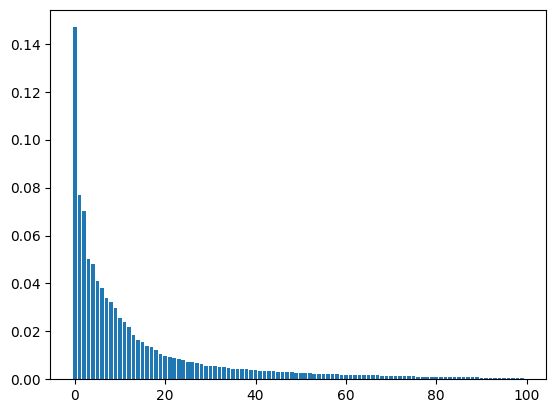

In [23]:
n_components = 100
plt.bar(np.arange(n_components), pca.explained_variance_ratio_[:n_components])
pca.explained_variance_ratio_[64:].sum()

In [24]:
PCA_N_DIM = 64
SEED = 33
PCA_KWARGS = dict(random_state=SEED)
TSNE_KAWRGS = dict(init='pca', learning_rate='auto', random_state=SEED)

def pca_and_tsne(data: np.ndarray, pca_n_dim: int = PCA_N_DIM, 
    pca_kwargs: typing.Optional[typing.Dict] = None, tsne_kwargs: typing.Optional[typing.Dict] = None):

    if pca_kwargs is None:
        pca_kwargs = PCA_KWARGS
    else:
        temp_kwargs = PCA_KWARGS.copy()
        temp_kwrags.update(pca_kwargs)
        pca_kwargs = temp_kwargs

    if tsne_kwargs is None:
        tsne_kwargs = TSNE_KAWRGS

    else:
        temp_kwrags = TSNE_KAWRGS.copy()
        temp_kwrags.update(tsne_kwargs)
        tsne_kwargs = temp_kwrags

    if data.ndim > 2:
        data = data.reshape(-1, data.shape[-1])

    pca = PCA(n_components=pca_n_dim, **pca_kwargs)
    data_pca = pca.fit_transform(data)
    tsne = TSNE(n_components=2, **tsne_kwargs)
    data_tsne = tsne.fit_transform(data_pca)

    return data_tsne

In [25]:
tsne_embedded_data = pca_and_tsne(all_embeddings.numpy())
tsne_embedded_data.shape

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(6370, 2)

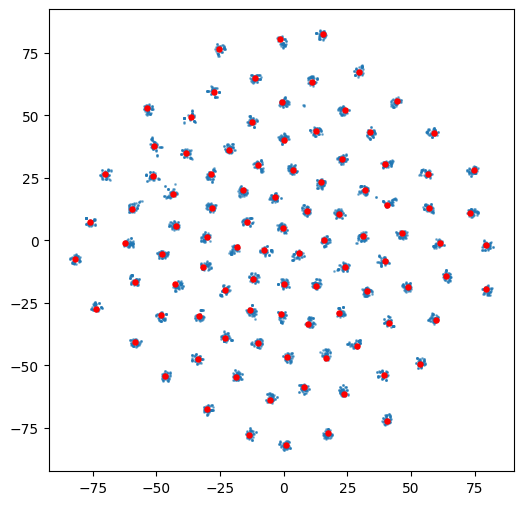

In [26]:
n_games = len(game_texts)
plt.figure(figsize=(6, 6))
plt.scatter(tsne_embedded_data[n_games:, 0], tsne_embedded_data[n_games:, 1], s=1, alpha=0.5)
plt.scatter(tsne_embedded_data[:n_games, 0], tsne_embedded_data[:n_games, 1], s=13, c='red')


## Let's see what happens if we try to fit a fitness model based on these embeddings?

In [27]:
embeddings_for_fitness = torch.cat([embeddings.unsqueeze(1), regrowth_embeddings], dim=1)
embeddings_for_fitness.shape

torch.Size([98, 65, 1536])

In [28]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv, (train_tensor, test_tensor), test_results = utils.model_fitting_experiment(embeddings_for_fitness, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'ecdf': -0.41457692307692307, 'game_rank': 0.7515624761581421}


### Test results:

{'ecdf': -0.41457692307692307, 'game_rank': 0.7515624761581421}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
384,4,8,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.0,-0.413609,0.007887,1,0.750586,0.020210,34
640,8,4,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.0,-0.413982,0.006953,2,0.729401,0.024580,121
128,2,16,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.0,-0.414837,0.005061,3,0.745339,0.010214,51
720,8,8,<function fitness_hinge_loss at 0x15e554550>,0.03,1,1536,0.0,-0.414930,0.013171,4,0.729674,0.020982,119
72,2,8,<function fitness_hinge_loss at 0x15e554550>,0.10,4,1536,0.0,-0.415192,0.010457,5,0.749440,0.020130,39
832,8,32,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.0,-0.415630,0.010939,6,0.753867,0.016414,24
280,2,64,<function fitness_hinge_loss at 0x15e554550>,0.03,4,1536,0.0,-0.415690,0.010907,7,0.756680,0.016762,16
76,2,8,<function fitness_hinge_loss at 0x15e554550>,0.10,8,1536,0.0,-0.415902,0.009945,8,0.747240,0.019966,45
448,4,16,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.0,-0.416083,0.007036,9,0.747943,0.020384,43
584,4,64,<function fitness_hinge_loss at 0x15e554550>,0.10,4,1536,0.0,-0.416333,0.009819,10,0.762643,0.013156,2


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
580,4,64,<function fitness_hinge_loss at 0x15e554550>,0.1,2,1536,0.0,-0.416793,0.009133,22,0.763229,0.011447,1
584,4,64,<function fitness_hinge_loss at 0x15e554550>,0.1,4,1536,0.0,-0.416333,0.009819,10,0.762643,0.013156,2
260,2,64,<function fitness_hinge_loss at 0x15e554550>,0.1,2,1536,0.0,-0.418781,0.007086,54,0.761159,0.012485,3
200,2,32,<function fitness_hinge_loss at 0x15e554550>,0.1,4,1536,0.0,-0.416446,0.008701,13,0.759961,0.013229,4
192,2,32,<function fitness_hinge_loss at 0x15e554550>,0.1,1,1536,0.0,-0.420268,0.004823,93,0.759896,0.014131,5
516,4,32,<function fitness_hinge_loss at 0x15e554550>,0.1,2,1536,0.0,-0.416850,0.009345,23,0.759844,0.011913,6
268,2,64,<function fitness_hinge_loss at 0x15e554550>,0.1,8,1536,0.0,-0.418793,0.008718,55,0.759557,0.012506,7
264,2,64,<function fitness_hinge_loss at 0x15e554550>,0.1,4,1536,0.0,-0.418361,0.007949,39,0.758971,0.013623,8
132,2,16,<function fitness_hinge_loss at 0x15e554550>,0.1,2,1536,0.0,-0.418341,0.006505,38,0.758542,0.011799,9
588,4,64,<function fitness_hinge_loss at 0x15e554550>,0.1,8,1536,0.0,-0.418461,0.008504,41,0.757995,0.013872,10


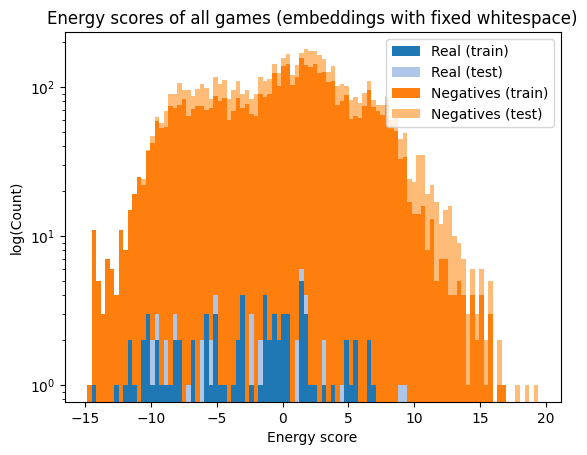

0.00033931728 0.119732 0.01


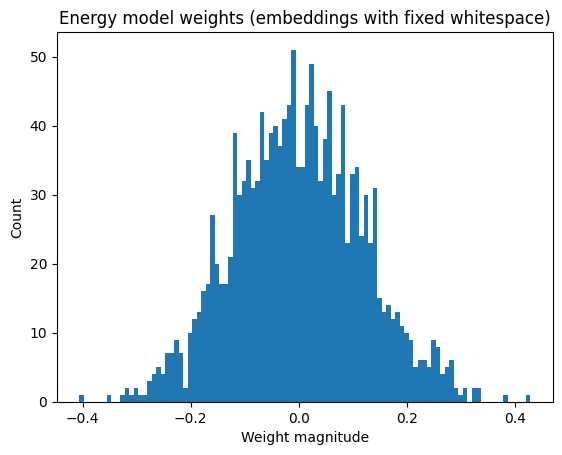

In [31]:
utils.visualize_cv_outputs(cv, train_tensor, test_tensor, test_results, histogram_title_note='embeddings with fixed whitespace')

In [30]:
cv.best_estimator_.fit(embeddings_for_fitness)
cv_fitness_model = cv.best_estimator_

output_path = '../models/cv_fitness_model_2023_01_18_from_embeddings.pkl.gz'
original_output_path = output_path[:]
i = 0
while os.path.exists(output_path):
    output_path = original_output_path + f'_{i}'
    i += 1

with gzip.open(output_path, 'wb') as f:
    pickle.dump(cv_fitness_model, f, protocol=pickle.HIGHEST_PROTOCOL)



## What if I concatante my features and the embeddings?

In [32]:
fitness_features_tensor = torch.load('../data/interactive-beta-and-regrowth-fitness-features-2023-01-19.pt')
print(fitness_features_tensor.shape, embeddings_for_fitness.shape)

features_and_embeddings = torch.cat([fitness_features_tensor, embeddings_for_fitness], dim=-1)
features_and_embeddings.shape

torch.Size([98, 65, 835]) torch.Size([98, 65, 1536])


torch.Size([98, 65, 2371])

In [33]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

cv_with_features, (train_tensor_with_features, test_tensor_with_features), test_results_with_features = utils.model_fitting_experiment(features_and_embeddings, test_param_grid,
    scoring_function=scoring, model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(test_results)


{'ecdf': -0.41457692307692307, 'game_rank': 0.7515624761581421}


## Trying to remove more linguistic information from the embeddings

In [8]:
RANDOM_SEED = 33
rng = np.random.default_rng(RANDOM_SEED)

VARIABLE_PATTERN = re.compile(r'(\?[a-zA-Z0-9_]+)')
PREFERENCE_NAME_PATTERN = re.compile(r'\(preference ([a-zA-Z0-9_]+)')
PREFERENCE_COUNT_PATTERN = re.compile(r'\(count[a-zA-z-]* ([a-zA-Z0-9_]+)')
PREDICATE_REMAPPING = {k: f'pred_func{i}' for i, k in enumerate(fitness_features.PREDICATE_FUNCTION_ARITY_MAP.keys())}
PREDICATE_REMAPPING_KEYS = list(sorted(PREDICATE_REMAPPING.keys(), key=lambda x: len(x), reverse=True))
all_object_type_names = sum([list(v) for k, v in room_and_object_types.CATEGORIES_TO_TYPES.items() if k != room_and_object_types.EMPTY_OBJECT], start=[])
all_object_type_names.extend(fitness_features.KNOWN_MISSING_TYPES)
rng.shuffle(all_object_type_names)
OBJECT_TYPE_REMAPPING = {k: f'obj_type{i}' for i, k in enumerate(all_object_type_names)}


def replace_variables(text: str, rng: typing.Optional[np.random.Generator] = None, random_seed: int = RANDOM_SEED):
    if rng is None:
        rng = np.random.default_rng(random_seed)

    unique_variables = set(VARIABLE_PATTERN.findall(text))
    valid_new_variables = set([f'?{v}' for v in string.ascii_lowercase] + [f'?{v}1' for v in string.ascii_lowercase]) - unique_variables

    if len(valid_new_variables) < len(unique_variables):
        print(unique_variables)
        print(valid_new_variables)
        raise ValueError(f'Not enough valid new variables to replace all variables in text: {text}')
    
    replacement_variables = rng.choice(list(valid_new_variables), size=len(unique_variables), replace=False)

    for old_variable, new_variable in zip(unique_variables, replacement_variables):
        text = text.replace(old_variable, new_variable)

    return text   


def replace_preference_names(text: str):
    preference_names = set(PREFERENCE_NAME_PATTERN.findall(text) + PREFERENCE_COUNT_PATTERN.findall(text))
    for i, preference_name in enumerate(preference_names):
        text = text.replace(preference_name, f'preference{i}')

    return text


def replace_predicate_names(text: str):
    for pred in PREDICATE_REMAPPING_KEYS:
        text = text.replace(f'({pred} ', f'({PREDICATE_REMAPPING[pred]} ')

    return text


def replace_object_type_names(text: str):
    for obj_type in OBJECT_TYPE_REMAPPING:
        text = text.replace(f' {obj_type}', f' {OBJECT_TYPE_REMAPPING[obj_type]}')
        text = text.replace(f':{obj_type}', f':{OBJECT_TYPE_REMAPPING[obj_type]}')

    return text


def scramble_game_text(game_text: str, rng: typing.Optional[np.random.Generator] = None, random_seed: int = RANDOM_SEED,
    update_variables: bool = True, update_preferences: bool = True, 
    update_predicates: bool = True, update_object_types: bool = True):

    if update_variables: game_text = replace_variables(game_text, rng, random_seed)
    if update_preferences: game_text = replace_preference_names(game_text)
    if update_predicates: game_text = replace_predicate_names(game_text)
    if update_object_types: game_text = replace_object_type_names(game_text)

    return game_text


In [9]:
scrambled_game_texts = [scramble_game_text(game) for game in game_texts]
scrambled_regrown_game_texts = [scramble_game_text(game) for game in regrown_game_texts]

In [13]:
scrambled_original_embeddings, scrambled_regrowth_embeddings = load_or_generate_embeddings(True, scrambled_game_texts, scrambled_regrown_game_texts, 'extra-scrambled')

torch.Size([98, 1536])


  0%|          | 0/98 [00:00<?, ?it/s]

torch.Size([98, 64, 1536])


In [14]:
all_scrambled_embeddings = torch.cat([scrambled_original_embeddings, scrambled_regrowth_embeddings.reshape(-1, scrambled_regrowth_embeddings.shape[-1])], dim=0)
all_scrambled_embeddings.shape

torch.Size([6370, 1536])

/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(6370, 2)


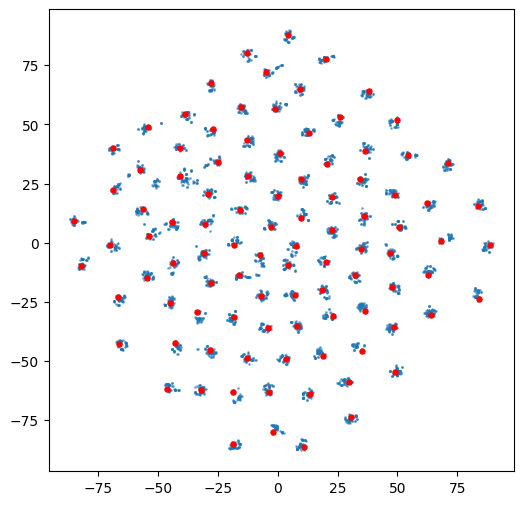

In [16]:
tsne_embedded_scrambled_data = pca_and_tsne(all_scrambled_embeddings.numpy())
print(tsne_embedded_scrambled_data.shape)

n_games = len(game_texts)
plt.figure(figsize=(6, 6))
plt.scatter(tsne_embedded_scrambled_data[n_games:, 0], tsne_embedded_scrambled_data[n_games:, 1], s=1, alpha=0.5)
plt.scatter(tsne_embedded_scrambled_data[:n_games, 0], tsne_embedded_scrambled_data[:n_games, 1], s=13, c='red')


In [17]:
scrambled_embeddings_for_fitness = torch.cat([scrambled_original_embeddings.unsqueeze(1), scrambled_regrowth_embeddings], dim=1)
scrambled_embeddings_for_fitness.shape

torch.Size([98, 65, 1536])

In [18]:
test_param_grid = [
    {
        'fitness__loss_function': [utils.fitness_hinge_loss], # [utils.fitness_hinge_loss_with_cross_example],
        'fitness__weight_decay': [0.0, 0.25, 1, 2],  
        'fitness__margin': [1, 2, 4, 8],
        'fitness__lr':  [1e-1, 3e-2, 1e-2, 3e-3],  # [1e-1, 3e-2, 1e-2, 3e-3],
        'fitness__k': [4, 8, 16, 32, 64],
        'fitness__batch_size': [2, 4, 8, 16],  # [1, 4, 8, 16],
        # 'fitness__alpha': [0, 0.25, 0.5, 0.75, 1], # [0, 0.1, 0.2, 0.3],  #
    },
]

model_kwargs = dict(output_activation=nn.Identity())
train_kwargs = dict(negative_score_reduction='none')
cv_kwargs = dict(refit='overall_ecdf')
scoring = utils.build_multiple_scoring_function(
    [utils.evaluate_fitness_overall_ecdf, utils.evaluate_fitness_single_game_rank],
    ['overall_ecdf', 'single_game_rank'],
)

scrambled_cv, (scrambled_train_tensor, scrambled_test_tensor), scrambled_test_results = utils.model_fitting_experiment(scrambled_embeddings_for_fitness, test_param_grid,
    scoring_function=scoring, verbose=1, 
    model_kwargs=model_kwargs, train_kwargs=train_kwargs, cv_kwargs=cv_kwargs)

print(scrambled_test_results)

Fitting 5 folds for each of 1280 candidates, totalling 6400 fits


/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


{'ecdf': -0.4860384615384616, 'game_rank': 0.55859375}


### Test results:

{'ecdf': -0.4860384615384616, 'game_rank': 0.55859375}

### CV results by overall ECDF:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
513,4,32,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.25,-0.434368,0.017746,1,0.657826,0.031302,175
641,8,4,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.25,-0.435032,0.031479,2,0.648581,0.037135,487
784,8,16,<function fitness_hinge_loss at 0x15e554550>,0.03,1,1536,0.00,-0.435364,0.013127,3,0.662487,0.030218,89
712,8,8,<function fitness_hinge_loss at 0x15e554550>,0.10,4,1536,0.00,-0.435910,0.017954,4,0.661953,0.029062,97
776,8,16,<function fitness_hinge_loss at 0x15e554550>,0.10,4,1536,0.00,-0.436523,0.015721,5,0.662930,0.028692,81
72,2,8,<function fitness_hinge_loss at 0x15e554550>,0.10,4,1536,0.00,-0.436748,0.018270,6,0.672969,0.033030,16
100,2,8,<function fitness_hinge_loss at 0x15e554550>,0.01,2,1536,0.00,-0.436819,0.017737,7,0.674453,0.032788,11
912,8,64,<function fitness_hinge_loss at 0x15e554550>,0.03,1,1536,0.00,-0.436918,0.020176,8,0.663177,0.029494,77
616,4,64,<function fitness_hinge_loss at 0x15e554550>,0.01,4,1536,0.00,-0.436953,0.014825,9,0.660820,0.029173,110
288,2,64,<function fitness_hinge_loss at 0x15e554550>,0.01,1,1536,0.00,-0.436964,0.023492,10,0.672279,0.033885,20


### CV results by mean single game rank:

,fitness__batch_size,fitness__k,fitness__loss_function,fitness__lr,fitness__margin,fitness__n_features,fitness__weight_decay,ecdf_mean,ecdf_std,ecdf_rank,game_rank_mean,game_rank_std,game_rank_rank
268,2,64,<function fitness_hinge_loss at 0x15e554550>,0.10,8,1536,0.0,-0.443847,0.015046,182,0.680924,0.033369,1
264,2,64,<function fitness_hinge_loss at 0x15e554550>,0.10,4,1536,0.0,-0.444803,0.014394,212,0.679049,0.033668,2
896,8,64,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.0,-0.441140,0.014072,103,0.678581,0.036083,3
584,4,64,<function fitness_hinge_loss at 0x15e554550>,0.10,4,1536,0.0,-0.442599,0.015386,143,0.677552,0.034080,4
576,4,64,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.0,-0.442603,0.018858,144,0.677148,0.034646,5
580,4,64,<function fitness_hinge_loss at 0x15e554550>,0.10,2,1536,0.0,-0.442739,0.016522,148,0.676055,0.034125,6
516,4,32,<function fitness_hinge_loss at 0x15e554550>,0.10,2,1536,0.0,-0.440624,0.014635,89,0.676003,0.033421,7
280,2,64,<function fitness_hinge_loss at 0x15e554550>,0.03,4,1536,0.0,-0.444359,0.015260,196,0.675690,0.033542,8
260,2,64,<function fitness_hinge_loss at 0x15e554550>,0.10,2,1536,0.0,-0.442535,0.016339,140,0.675521,0.036834,9
512,4,32,<function fitness_hinge_loss at 0x15e554550>,0.10,1,1536,0.0,-0.442293,0.017137,132,0.674479,0.045758,10


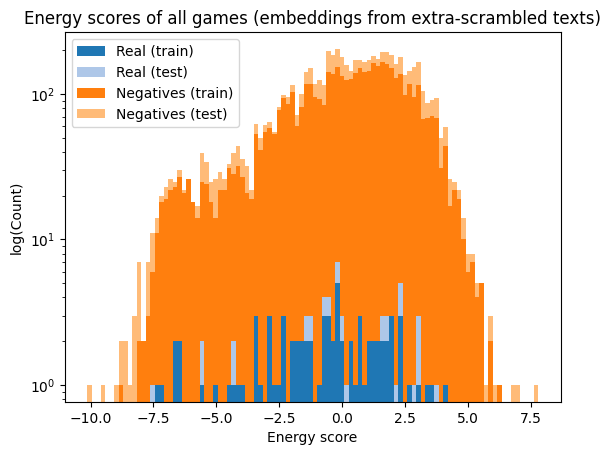

3.016383e-05 0.02876222 0.0013193781


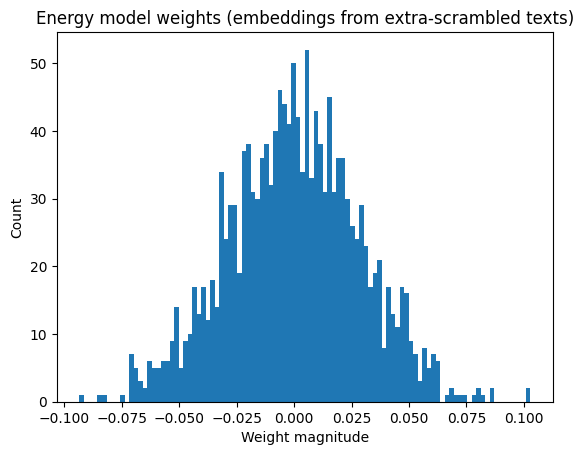

In [19]:
utils.visualize_cv_outputs(scrambled_cv, scrambled_train_tensor, scrambled_test_tensor, scrambled_test_results, histogram_title_note='embeddings from extra-scrambled texts')

In [ ]:
k = 20
set(torch.topk(scrambled_cv.best_estimator_['fitness'].model.fc1.weight.data, k=k).indices.squeeze().tolist()).intersection(set(torch.topk(cv.best_estimator_['fitness'].model.fc1.weight.data, k=k).indices.squeeze().tolist()))

In [ ]:
set(torch.topk(scrambled_cv.best_estimator_['fitness'].model.fc1.weight.data, k=k, largest=False).indices.squeeze().tolist()).intersection(set(torch.topk(cv.best_estimator_['fitness'].model.fc1.weight.data, k=k, largest=False).indices.squeeze().tolist()))

In [ ]:
game_texts[89]

In [ ]:
scrambled_game_texts[89]

In [ ]:
scrambled_regrown_game_texts[89 * 64 + 10]

In [ ]:
original_game_index = 67
regrowth_index = 37
utils.display_game_diff_html(scrambled_game_texts[original_game_index], scrambled_regrown_game_texts[original_game_index * 64 + regrowth_index])

In [ ]:
def find_in_train_test_split(full_tensor: torch.Tensor, train_tensor: torch.Tensor, test_tensor: torch.Tensor, index: int):
    found_in_train = (full_tensor[index, :2, :] == train_tensor[:, :2, :]).all(dim=-1).all(dim=-1).nonzero()
    if found_in_train.ndim > 0:
        return 'train', found_in_train.item()
    
    found_in_test = (full_tensor[index, :2, :] == test_tensor[:, :2, :]).all(dim=-1).all(dim=-1).nonzero()
    if found_in_test.ndim > 0:
        return 'test', found_in_test.item()
    
    return None, None

In [ ]:
find_in_train_test_split(scrambled_embeddings_for_fitness, scrambled_train_tensor, scrambled_test_tensor, 67)

In [ ]:
utils.evaluate_energy_contributions(scrambled_cv, scrambled_train_tensor, 70 * 64 + 37, list(range(scrambled_train_tensor.shape[-1])), scrambled_embeddings_for_fitness, scrambled_game_texts, scrambled_regrown_game_texts, top_k=5)

In [ ]:
original_game_index = 20
regrowth_index = 3

text = scrambled_regrown_game_texts[original_game_index * 64 + regrowth_index]
modified_text = text  # text.replace('obj_type65', 'obj_type25')


# utils.display_game_diff_html(scrambled_game_texts[original_game_index], scrambled_regrown_game_texts[original_game_index * 64 + regrowth_index])
utils.display_game_diff_html(scrambled_game_texts[original_game_index], modified_text)
# utils.display_game_diff_html(modified_text, scrambled_regrown_game_texts[original_game_index * 64 + regrowth_index])

result = embed_text(modified_text.strip())
e_from_regrown = torch.tensor(result.data[0].embedding)
scrambled_cv.best_estimator_.transform(e_from_regrown).item()

In [ ]:
text = scrambled_game_texts[67]
# text = scrambled_regrown_game_texts[67 * 64 + 37]
modified_text = text.replace('obj_type65', 'obj_type25')

original_game_index = 67
regrowth_index = 37
# utils.display_game_diff_html(scrambled_game_texts[original_game_index], scrambled_regrown_game_texts[original_game_index * 64 + regrowth_index])
utils.display_game_diff_html(scrambled_game_texts[original_game_index], modified_text)
# utils.display_game_diff_html(modified_text, scrambled_regrown_game_texts[original_game_index * 64 + regrowth_index])

result = embed_text(modified_text.strip())
e_from_original = torch.tensor(result.data[0].embedding)
# scrambled_cv.best_estimator_.transform(e).item()

In [ ]:
e_from_original - e_from_regrown

In [ ]:
text = scrambled_regrown_game_texts[67 * 64 + 37]
modified_text_from_regrown = text.replace('obj_type65', 'obj_type25')

text = scrambled_game_texts[67]
modified_text_from_original = text.replace('obj_type65', 'obj_type25')

In [ ]:
modified_text_from_regrown.strip() == modified_text_from_original.strip()

In [ ]:
whitespace_pattern.sub(' ', modified_text_from_regrown) == whitespace_pattern.sub(' ', modified_text_from_original)

In [ ]:
print(modified_text_from_original)